# Iris dataset backpropagation
By Gerrit van de Bunt, 1756708, 2020-2021\
In this short notebook we will analyse the iris dataset and, based on this analysis, configure a Neural Network using our own code to train upon and classify the entries in this dataset.

# Step 0
Import the necessary tools.\
**Note: Due to jupyter notebook importing issues, we will be using a couple of cells to define all the code in our notebook, which drastically increases it's size.** 

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import pandas
import random
import time

In [2]:
# Activation classes. The idea is as follows;
# The classes should have attributes, but should ultimately be callable to be used in the Perceptrons, in order
# to return an output.

# To this end, make sure that implemented classes have an activate() function that only takes a int or float input
# and outputs a int or float.

from typing import Union
import math

class Step:
    """Step-based activation. If the sum of the input is above the treshold, the output is 1. Otherwise,
    the output is 0."""
    def __init__(self, treshold: Union[int, float] = 0):
        self.treshold = treshold

    def activate(self, input: Union[int, float]):
        if input >= self.treshold:
            return 1
        else:
            return 0

class Sigmoid:
    """Sigmoid-based activation. The output is defined by the sigmoid function."""
    def __init__(self):
        """Creates the object."""

    def activate(self, input: Union[int, float]):
        return 1 / (1 + (math.e ** -input))


In [3]:
# Neuron class. Takes a list of inputs, applies a list of weights to them, adds a bias,
# then applies the sum of that to the activation function and returns an output.

from typing import List, Union

class Neuron:
    """Neuron class. To initialise, takes a list of weights, an activation function (normally Sigmoid().activate()), and a bias (optional).
    Once initialised, can be activated by giving a list of inputs (with equal elements to the amount of weights)"""
    def __init__(self, weights: List[Union[int, float]], activation: callable, ID=0, bias: Union[int,float] = 0.0):
        """Initialises the neuron."""
        # FUNCTIONAL VARIABLES (Private)
        self.__weights = weights
        self.__activation = activation
        self.__bias = bias

        self.__newweights = []
        self.__newbias = 0

        # LOGGING VARIABLES (Public)
        self.ID = ID  # Identifier for Perceptron, for debugging.

        self.error = 0  # Error calculated by the error methods.

        self.hasrun = False  # Whether the neuron has been activated or not.
        self.input = []  # Inputs of previous activations
        self.output = []  # Output of previous activations

    def getweights(self) -> List[Union[int, float]]:
        """Returns the current weights."""
        return self.__weights

    def setweights(self,weights: List[Union[int, float]]):
        """Changes the weights on this neuron by using a supplied weightslist.
        For proper use in the PerceptronLayer class, the input has to have the same
        amount of elements as the original weights list."""
        if not len(weights) == len(self.getweights()):
            raise Exception("Amount of supplied weights does not equal the amount of current weights @ Perceptron {}".format(self.ID))
        self.__weights = weights

    def getactivation(self) -> callable:
        """Returns the current activation function."""
        return self.__activation

    def setactivation(self, func: callable):
        """Changes the activation function on this neuron."""
        self.__activation = func

    def getbias(self) -> Union[int, float]:
        """Returns the current bias for this neuron."""
        return self.__bias

    def setbias(self, b: Union[int, float]):
        """Changes the current bias on this neuron."""
        self.__bias = b

    def activate(self,inputs: List[Union[int, float]]) -> Union[int,float]:
        """Activates the Perceptron by supplying inputs."""
        # RESETS
        self.hasrun = False
        # PRECHECKS
        if not len(inputs) == len(self.__weights):
            raise Exception("Amount of inputs is not equal to the amount of weights @ Perceptron {}".format(self.ID))
        # PROCESSING
        weightedlist = []  # List with processed inputs (input*weight)

        for indx in range(len(self.__weights)):
            weightedlist.append(self.__weights[indx] * inputs[indx])

        output = self.__activation(sum(weightedlist) + self.__bias)
        # Consider evaluation succesful past this point; get logging variables.
        self.hasrun = True
        self.input.append(inputs)
        self.output.append(output)

        return output

    def erroroutput(self, target: Union[int,float], learningrate: Union[int,float]):
        """Calculates the error of an output neuron."""
        if not self.hasrun:
            raise Exception("Run the Neuron first! @ Neuron {}".format(self.ID))
        gradients = []
        deltaweights = []
        deltabias = 0
        newweights = []
        newbias = 0
        # Bepaal de error
        output = self.output[-1]
        error = output * (1-output) * -(target-output)
        for inp in self.input[-1]:
            gradients.append(inp * error)  # De output van een voorgaande node is gelijk aan de input op deze node op de relevante index
        for grad in gradients:
            deltaweights.append(learningrate * grad)
        deltabias = learningrate * error

        self.error = error
        self.__newweights = [self.__weights[i] - deltaweights[i] for i in range(len(self.getweights()))]
        self.__newbias = self.getbias() - deltabias

    def errorhidden(self, connections: List[Union[int,float]], errors: List[Union[int,float]], learningrate: Union[int,float]):
        """Calculates the error of a hidden layer neuron"""
        if not self.hasrun:
            raise Exception("Run the Neuron first! @ Neuron {}".format(self.ID))
        if len(connections) != len(errors):
            raise Exception("Amount of connections from this neuron should equal the amount of errors from neurons @ Neuron {}".format(self.ID))
        gradients = []
        deltaweights = []
        deltabias = 0
        newweights = []
        newbias = 0
        sum = 0  # Sum of (Wi,j * Delta(j))
        # Bepaal de error
        output = self.output[-1]
        for i in range(len(connections)):  # Bepaal eerst de som van de vermenigvuldigingen tussen de verbindingen en de errors.
            sum += connections[i] * errors[i]
        error = output * (1-output) * sum  # Bepaal dan uiteindelijk de error.
        for inp in self.input[-1]:
            gradients.append(inp * error)  # De output van een voorgaande node is gelijk aan de input op deze node op de relevante index
        for grad in gradients:
            deltaweights.append(learningrate * grad)
        deltabias = learningrate * error

        self.error = error
        self.__newweights = [self.__weights[i] - deltaweights[i] for i in range(len(self.getweights()))]
        self.__newbias = self.getbias() - deltabias

    def update(self):
        """Updates the weights and bias using stored new weights and bias."""
        self.setbias(self.__newbias)
        self.setweights(self.__newweights)

    def __str__(self) -> str:
        """Returns a string representing the object and it's variables."""
        output = ""
        output += "NEURON ID: {}\n\n".format(self.ID)

        output += "WEIGHTS: {}\n".format(self.getweights())
        output += "ACTIVATION: {}\n".format(self.getactivation().__name__)
        output += "BIAS: {}\n".format(self.getbias())

        if self.hasrun:
            output += "SUCCESFUL ACTIVATION \n\n".format(self.hasrun)
            output += "INPUT: {}\n".format(self.input)
            output += "OUTPUT: {}\n".format(self.output)
        else:
            output += "ACTIVATION PENDING/FAILED\n"

        return output

In [4]:
# NeuronLayer defines the layers in the network. This is where the Neuron Class is used.

# By default, all the Layers must be connected, so each neuron in the network must have equally as many
# weights as one another, and the amount of weights on all perceptrons should equal the amount of connections from one layer to the
# other on a per-neuron basis.

from typing import List, Union, Any

class NeuronLayer:
    """Defines a layer in a NeuronNetwork."""
    def __init__(self, neurons: List[Neuron], ID: Any = 0):
        self.neurons = neurons
        self.outputs = []

    def activate(self, inputlist: List[Union[int, float]]):
        """Runs the inputlist through all perceptrons of the network and saves the output."""
        self.outputs = []
        for i in self.neurons:
            i.activate(inputlist)
            self.outputs.append(i.output[-1])

In [5]:
# The NeuronNetwork houses **all** the layers of the network.

from typing import List, Union, Any  # Onschuldige library die alleen beter laat zien wat voor soorten inputs er verwacht worden.

class NeuronNetwork:
    """Defines the neuron network; wraps all the given layers into this network."""
    def __init__(self, layers: List[NeuronLayer], learningrate: Union[int,float] = 0.3, ID: Any = 0,):
        """Initialises a neuron network. Handles the connections between the layers."""
        self.hiddenlayers = layers
        self.learningrate = learningrate
        self.input = []
        self.output = []

        self.ID = ID
        self.hasrun = False



    def feed_forward(self, inputs: List[Union[int,float]]) -> List[Union[int,float]]:
        """Starts the network, feeds in the inputs, runs it through all the layers and returns the output
        of the final layer."""
        self.hasrun = False
        totalinputs = inputs.copy()  # Keep both lists unlinked; original list will be saved for debugging.
        for layer in self.hiddenlayers:
            layer.activate(totalinputs)
            totalinputs = layer.outputs.copy()  # Same deal here

        self.input = inputs
        self.output = totalinputs
        self.hasrun = True

        return totalinputs

    def backpropagation(self, actualoutput):
        outputlayer = self.hiddenlayers[-1]

        if len(outputlayer.neurons) != len(actualoutput):
            raise Exception("Not enough outputs for each neuron in the output layer @ NeuronNetwork {}".format(self.ID))

        for i in range(len(outputlayer.neurons)):
            outputlayer.neurons[i].erroroutput(actualoutput[i],self.learningrate)
        # Nu komt het lastige gedeelte...
        # Amount of connections is equal to the amount of neurons in the previous layer!!
        # Currentlayer (i) : Target to call .errorhidden() on. Also get index in the neuron list.
        # Nextlayer (i+1) : Target to get weights from. Use index acquired in the previous layer.
        for lindx in range(len(self.hiddenlayers)-2,-1,-1):
            for i in range(len(self.hiddenlayers[lindx].neurons)):
                weights = []
                errors = []
                for neuron in self.hiddenlayers[lindx+1].neurons:
                    weights.append(neuron.getweights()[i])  # Gets the weights that this neuron connects to on neurons in the next layer
                    errors.append(neuron.error)  # Gets the error at the same time.
                self.hiddenlayers[lindx].neurons[i].errorhidden(weights,errors,self.learningrate)

    def update(self):
        """Updates all the weights and biases in the network immediately, given
        that all neurons have had their """
        for layer in self.hiddenlayers:
            for neuron in layer.neurons:
                neuron.update()

    def train(self, inputs: List[List[int]], actualoutputs: List[List[int]], epochs: int = 40, errortreshold: float = 0.1) -> None:
        error = errortreshold+1
        while epochs > 0 and error >= errortreshold:
            for i in range(len(inputs)):
                self.feed_forward(inputs[i])
                self.backpropagation(actualoutputs[i])
                self.update()
                error = self.error(inputs,actualoutputs)  # MSE
                if error < errortreshold:
                    break
            epochs -= 1

    def error(self, inputs: List[List[Union[int,float]]], actualoutputs: List[List[Union[int,float]]]) -> float:
        """Calculates the MSE of this network's output layer over a training set."""
        outputs = []
        sumoutputs = []
        for i in range(len(inputs)):
            self.feed_forward(inputs[i])
            outputs.append(self.output)
            # Verwijder ook hier weer de resulterende inputs en outputs, die willen we niet; error moet gezien
            # worden als een functie zonder side-effects.
            for neuronlayer in self.hiddenlayers:
                for neuron in neuronlayer.neurons:
                    del neuron.output[-1]
                    del neuron.input[-1]

        for i1 in range(len(outputs)):
            for i2 in range(len(outputs[i1])):
                sumoutputs.append((actualoutputs[i1][i2] - outputs[i1][i2])**2)

        return sum(sumoutputs) / len(outputs)

    def __str__(self):
        """Tries to print out the network in a readable manner.
        Additional information is available once the network has been run once."""
        output = ""
        output += "NEURONNETWORK ID: {}\n".format(self.ID)
        if self.hasrun:
            output += "INPUT: {}\nV\n".format(self.input)
        for layer in self.hiddenlayers:
            for i in layer.neurons:
                output += "[{} + {}]\n".format([round(x,4) for x in i.getweights()],round(i.getbias(),4))
            if self.hasrun:
                output += "OUTPUT: {}\n".format(layer.outputs)
            output += "V\n"
        if self.hasrun:
            output += "FINAL OUTPUT: {}\n".format(self.output)
        else:
            output += "ACTIVATION PENDING\n"
        return output


# Stap 1 - Data collection
Importeer de dataset en kijk naar de eerste gegevens

In [6]:
data = load_iris(as_frame=True)
frame = data["frame"]
frame

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [7]:
frame.describe(include='all')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


# Stap 2 - Data analysis
We willen kijken of er een correlatie gevonden kan worden tussen de targets en de verschillende attributen.
Hiervoor gebruiken we een pearson correlatie matrix

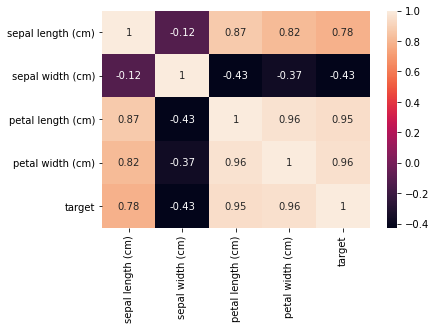

In [8]:
corrs = frame.corr()
sns.heatmap(corrs,annot=True)

We zien hier dat de sepal breedte een negatieve correlatie heeft, terwijl de petal lengtes, breedte en sepal lengte het meetste mee tellen.

**Notitie: Deze dataset is al helemaal 'clean'; Data cleanup en Data preparation is hier niet nodig, deze stappen slaan we dus over. We zullen wel tijdens het organiseren van de testdata de data overzetten naar een list; kennelijk ontstaan er makkelijk errors als we direct een pandas dataframe gebruiken. Verder maken we ook dummies van y, zodat deze in ons netwerk passen.**

# Stap 3 - Model Training
Nu gaan we ons model trainen; we gaan ons neurale netwerk opzetten!
We hebben te maken met drie verschillende classificeringen (0, 1 en 2), en vier mogelijke features (sepal length, sepal width, petal length, petal width)
O.b.v. onze correlatie analyse willen we gebruik maken van de meest kansrijke features; De beste hiervoor zijn sepal length, petal length en petal width


In [9]:
xframe = frame[["sepal length (cm)","petal length (cm)","petal width (cm)"]]
xframe

,sepal length (cm),petal length (cm),petal width (cm)
0,5.1,1.4,0.2
1,4.9,1.4,0.2
2,4.7,1.3,0.2
3,4.6,1.5,0.2
4,5.0,1.4,0.2
...,...,...,...
145,6.7,5.2,2.3
146,6.3,5.0,1.9
147,6.5,5.2,2.0
148,6.2,5.4,2.3


In [10]:
x = xframe.values.tolist()
x

[[5.1, 1.4, 0.2],
 [4.9, 1.4, 0.2],
 [4.7, 1.3, 0.2],
 [4.6, 1.5, 0.2],
 [5.0, 1.4, 0.2],
 [5.4, 1.7, 0.4],
 [4.6, 1.4, 0.3],
 [5.0, 1.5, 0.2],
 [4.4, 1.4, 0.2],
 [4.9, 1.5, 0.1],
 [5.4, 1.5, 0.2],
 [4.8, 1.6, 0.2],
 [4.8, 1.4, 0.1],
 [4.3, 1.1, 0.1],
 [5.8, 1.2, 0.2],
 [5.7, 1.5, 0.4],
 [5.4, 1.3, 0.4],
 [5.1, 1.4, 0.3],
 [5.7, 1.7, 0.3],
 [5.1, 1.5, 0.3],
 [5.4, 1.7, 0.2],
 [5.1, 1.5, 0.4],
 [4.6, 1.0, 0.2],
 [5.1, 1.7, 0.5],
 [4.8, 1.9, 0.2],
 [5.0, 1.6, 0.2],
 [5.0, 1.6, 0.4],
 [5.2, 1.5, 0.2],
 [5.2, 1.4, 0.2],
 [4.7, 1.6, 0.2],
 [4.8, 1.6, 0.2],
 [5.4, 1.5, 0.4],
 [5.2, 1.5, 0.1],
 [5.5, 1.4, 0.2],
 [4.9, 1.5, 0.2],
 [5.0, 1.2, 0.2],
 [5.5, 1.3, 0.2],
 [4.9, 1.4, 0.1],
 [4.4, 1.3, 0.2],
 [5.1, 1.5, 0.2],
 [5.0, 1.3, 0.3],
 [4.5, 1.3, 0.3],
 [4.4, 1.3, 0.2],
 [5.0, 1.6, 0.6],
 [5.1, 1.9, 0.4],
 [4.8, 1.4, 0.3],
 [5.1, 1.6, 0.2],
 [4.6, 1.4, 0.2],
 [5.3, 1.5, 0.2],
 [5.0, 1.4, 0.2],
 [7.0, 4.7, 1.4],
 [6.4, 4.5, 1.5],
 [6.9, 4.9, 1.5],
 [5.5, 4.0, 1.3],
 [6.5, 4.6, 1.5],
 [5.7, 4.5

In [11]:
yframe = frame["target"]
yframe

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int32

In [12]:
ydummies = pandas.get_dummies(frame["target"])
ydummies

,0,1,2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
145,0,0,1
146,0,0,1
147,0,0,1
148,0,0,1


In [13]:
y = ydummies.values.tolist()
y

[[1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0,

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x,y)

De data is nu opgesteld, nu moeten we ons model opstellen en trainen. We hebben te maken met 3 features, dus 3 inputs. De eerste layer heeft dus 3 neurons (hoeft niet gedefinieerd te worden in ons netwerk).\
\
De tweede layer zullen we uit een varierend aantal neurons opbouwen om te testen waar de accuracy het beste is.\
\
De derde layer zal drie neurons hebben; deze staat gelijk aan het aantal mogelijke classificaties. De neuron
met de hoogste waarde in deze layer toont aan welke classificatie het netwerk geeft aan een gegeven set features.\
\
Voor elke neuron geven we random weights mee om mee te beginnen.

**Pas op: onderstaande cel duurt heel lang om te runnen bij een hoog aantal epochs.**

In [15]:
# Definitions
inputs = len(xframe.columns)  # Aantal features
outputs = len(yframe.unique())  # Aantal outputs
neurons = 3  # Aantal neurons in de eerste layer.
eta = 0.1  # Learning rate
epochs = 40  # Aantal keer dat het netwerk door de **hele** trainset heen loopt
errortolerance = 0.01  # Als de MSE onder deze grens ligt, dan houdt het netwerk op met trainen
# End of definitions
start = time.time()
l1 = NeuronLayer([])
l2 = NeuronLayer([])

for i in range(neurons):  # Tweede layer
    n = Neuron([random.random() for i in range(inputs)],Sigmoid().activate)
    l1.neurons.append(n)
    
for j in range(outputs):  # Output layer
    n = Neuron([random.random() for i in range(neurons)],Sigmoid().activate)
    l2.neurons.append(n)

ntwrk = NeuronNetwork([l1,l2],learningrate=eta)
ntwrk.train(list(x_train),list(y_train),epochs=epochs,errortreshold=errortolerance)
end = time.time()
print("Training network took {} seconds.".format((end-start)))

Training network took 9.512921571731567 seconds.


In [16]:
# score = accuracy_score(ntwrk.feed_forward([x for x in x_test]),y_test)
# y_pred = [ntwrk.feed_forward(x) for x in x_test]
# accuracy_score(y_pred,y_test)
y_pred = [ntwrk.feed_forward(x) for x in x_test]
indexes_y_pred = [y_pred[i].index(max(y_pred[i])) for i in range(len(y_pred))]
indexes_y_true = [y_test[i].index(max(y_test[i])) for i in range(len(y_test))]
print("Accuracy network:")
print(accuracy_score(indexes_y_pred,indexes_y_true))
print("Error network (RMSE) (trainset):")
print(np.sqrt(ntwrk.error(list(x_train),list(y_train))))
print("Error network (RMSE) (testset):")
print(np.sqrt(ntwrk.error(list(x_test),list(y_test))))

Accuracy network:
0.631578947368421
Error network (RMSE) (trainset):
0.5856579236367815
Error network (RMSE) (testset):
0.6049563694087015
